In [1]:
# This notebook illustrates handling the September 2024 Demo of the 18-month epi evaluation scenario 2 question 9

# Import funman related code
import os
from funman import MODE_ODEINT, MODE_SMT, Interval, LinearConstraint
import json
import pandas as pd
import logging
import matplotlib.pyplot as plt
from helpers import run, get_model, setup_common, get_request, report


RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario_base_request.json")

models = {
    "sidarthe_observables":  os.path.join(
    EXAMPLE_DIR, "SIDARTHE.model.with.observables.json"),
    "sirhd": os.path.join(
    EXAMPLE_DIR, "sirhd.json"),
    "sirhd-vac": os.path.join(
    EXAMPLE_DIR, "sirhd-vac.json"),
}

requests = {
    "sidarthe_observables": REQUEST_PATH,
    "sirhd-vac": os.path.join(EXAMPLE_DIR, "sirhd-vac-request.json"),
    "sirhd": None
}

states = {
    "sidarthe_observables": ['Susceptible', 'Diagnosed', 'Infected', 'Ailing', 'Recognized', 'Healed', 'Threatened', 'Extinct'],
    "sirhd": ["S", "I", "R", "H", "D"],
    "sirhd-vac": ["S_v", "I_v", "R_v", "H_v", "S_u", "I_u", "R_u", "H_u", "D"],
}


request_params = {}
request_results = {}


# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario

MAX_TIME=3
STEP_SIZE=1
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))
# model_str = "sidarthe_observables"


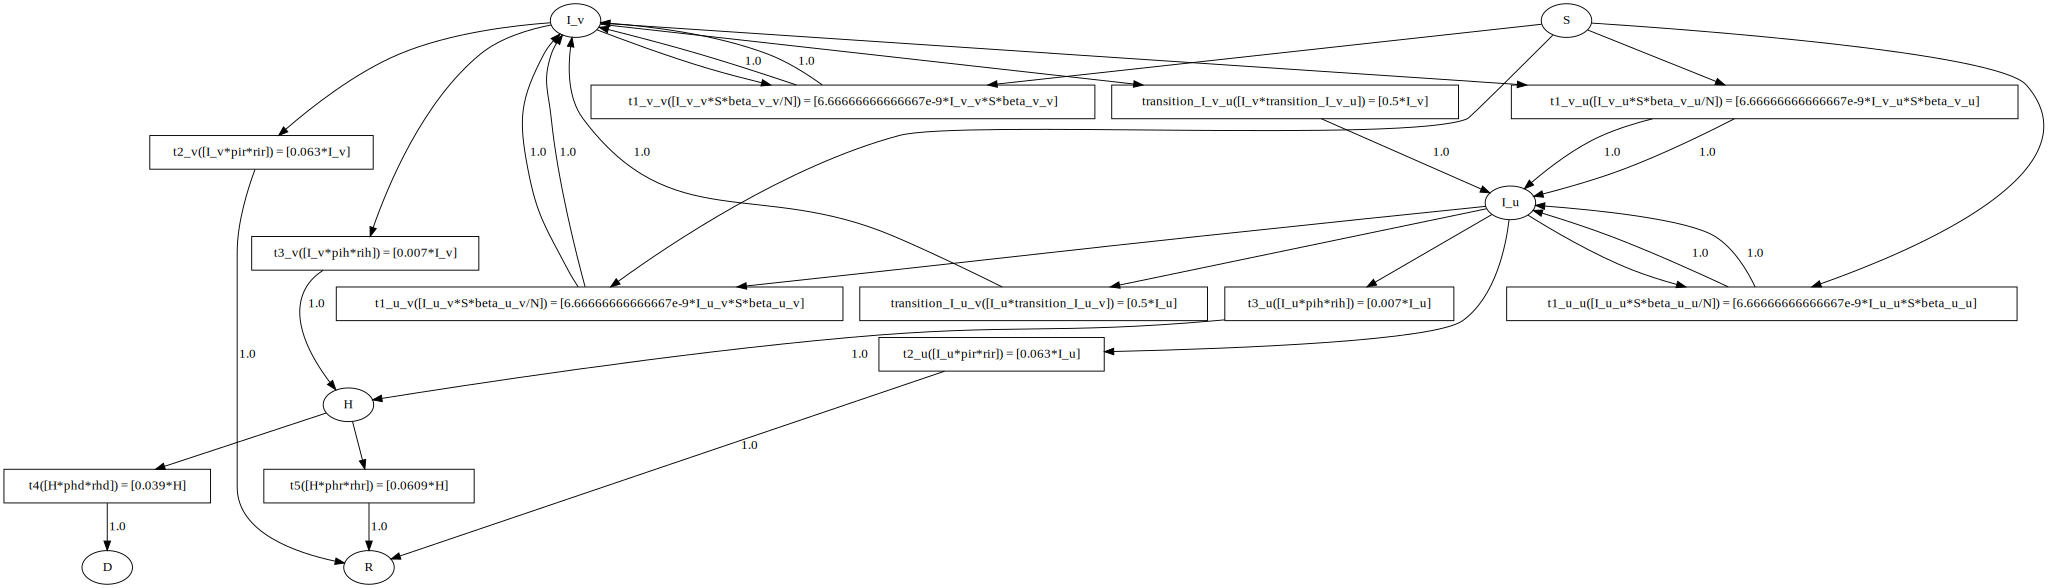

In [27]:
# Stratify model with vaccination status

from typing import Dict, List, Optional
from funman.model.generated_models.petrinet import Model1, Parameter, Rate, State,Transition, Properties, Model, Semantics, OdeSemantics
from funman.model.petrinet import GeneratedPetriNetModel, PetrinetModel


model_str = "sirhd"
(model, request) = get_model(models[model_str])
to_plot = model._state_var_names() + model._observable_names()


def stratify(self: PetrinetModel, state_var: str, strata: List[str], strata_parameter:Optional[str]=None, strata_transitions=[], self_strata_transition=False):
    
    # get state variable
    state_vars: List[State] = [s for s in self._state_vars() if self._state_var_name(s) == state_var]
    assert len(state_vars) == 1, "Found more than one State variable for {state_var}"
    original_var = state_vars[0]
    new_vars = [State(id=f"{original_var.id}_{level}", name=f"{original_var.name}_{level}", description=f"{original_var.description} Stratified wrt. {level}", grounding=original_var.grounding, units=original_var.units) for level in strata]
    
    # get new transitions
    transitions: Dict[str, Transition] = {t.id: t for t in self._transitions() if original_var.id in t.input or original_var.id in t.output}
    other_transitions = {t.id: t for t in self._transitions() if t.id not in transitions}
    
    src_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id not in t.output}
    dest_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id not in t.input and original_var.id in t.output}
    src_and_dest_transitions: Dict[str, Transition] = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id in t.output }
    
    # Replicate transitions where original_var is in source
    new_src_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=[(s if s!= original_var.id else f"{s}_{level}") for s in t.input], 
                   output=t.output, 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id, t in src_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in destination
    new_dest_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=t.input, 
                   output=[(s if s!= original_var.id else f"{s}_{level}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id,t in dest_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in source and destination
    new_src_dest_transitions = [
        Transition(id=f"{t.id}_{level_s}_{level_t}", 
                   input=[(s if s!= original_var.id else f"{s}_{level_s}") for s in t.input], 
                   output=[(s if s!= original_var.id else f"{s}_{level_t}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level_s}_{level_t}", description=(f"{t.properties.description} Stratified wrt. {level_s}, {level_t}." if t.properties.description else t.properties.description))) 
        for t_id,t in src_and_dest_transitions.items()
        for level_s in strata
        for level_t in strata
        if t_id in strata_transitions or level_s == level_t
        ]
    
    new_transitions = new_src_transitions +new_dest_transitions + new_src_dest_transitions
        
    # Modify rates by substituting fresh versions of the strata_parameter
    old_rates = {t_id: self._transition_rate(t) for t_id, t in transitions.items()}
    other_rates = {r.target: r for r in self.petrinet.semantics.ode.rates if r.target in other_transitions}
    
    src_only_rates = [Rate(target=f"{t_id}_{level}", expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level}").replace(state_var, f"{state_var}_{level}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level}"))) for t_id,r in old_rates.items() if t_id in src_only_transitions for level in strata]

    dest_only_rates = [Rate(target=f"{t_id}_{level}", expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level}").replace(state_var, f"{state_var}_{level}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level}"))) for t_id,r in old_rates.items() if t_id in dest_only_transitions for level in strata]

    src_and_dest_rates = [Rate(target=f"{t_id}_{level_s}_{level_t}", expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level_s}_{level_t}").replace(state_var, f"{state_var}_{level_s}_{level_t}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level_s}_{level_t}"))) for t_id,r in old_rates.items() if t_id in src_and_dest_transitions for level_s in strata for level_t in strata]

    new_rates = src_only_rates + dest_only_rates + src_and_dest_rates

    new_states = new_vars + [s for s in self.petrinet.model.states.root if s not in state_vars]
    
    # FIXME update with new states by splitting old state values
    new_initials = self.petrinet.semantics.ode.initials
    
    # FIXME update with split parameters
    new_parameters = self.petrinet.semantics.ode.parameters
    
    # FIXME update with splits
    new_observables = self.petrinet.semantics.ode.observables
    
    self_strata_transitions = [Transition(id=f"transition_{state_var}_{level_s}_{level_t}", input=[f"{state_var}_{level_s}"], output=[f"{state_var}_{level_t}"], grounding=None, properties={"name": f"transition_{state_var}_{level_s}_{level_t}"}) for level_s in strata for level_t in strata if level_s != level_t]
    self_strata_rates = [Rate(target=f"transition_{state_var}_{level_s}_{level_t}", expression=f"{state_var}_{level_s}*transition_{state_var}_{level_s}_{level_t}") for level_s in strata for level_t in strata if level_s != level_t]
    self_strata_parameters = [Parameter(id=f"transition_{state_var}_{level_s}_{level_t}", name=f"transition_{state_var}_{level_s}_{level_t}", description="Transition rate parameter between {state_var} strata {level_s} and {level_t}.", value=1.0/float(len(strata))) for level_s in strata for level_t in strata if level_s != level_t]
    
    new_model = GeneratedPetriNetModel(petrinet=Model(header=self.petrinet.header,
                      properties=self.petrinet.properties,
                      model=Model1(
                          states=new_states, 
                          transitions=[*new_transitions, *other_transitions.values(), *self_strata_transitions]
                          ),
                      semantics=Semantics(
                          ode=OdeSemantics(
                              rates=[*new_rates, *other_rates.values(), *self_strata_rates], 
                              initials=new_initials, 
                              parameters=new_parameters+self_strata_parameters, 
                              observables=new_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, span=self.petrinet.semantics.span),
                      metadata=self.petrinet.metadata
                      ))

    return new_model #new_rates, transitions, new_transitions # dest_only_rates #original_var, new_vars, new_transitions
    
m = stratify(model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t1"], self_strata_transition=True)
m.to_dot()


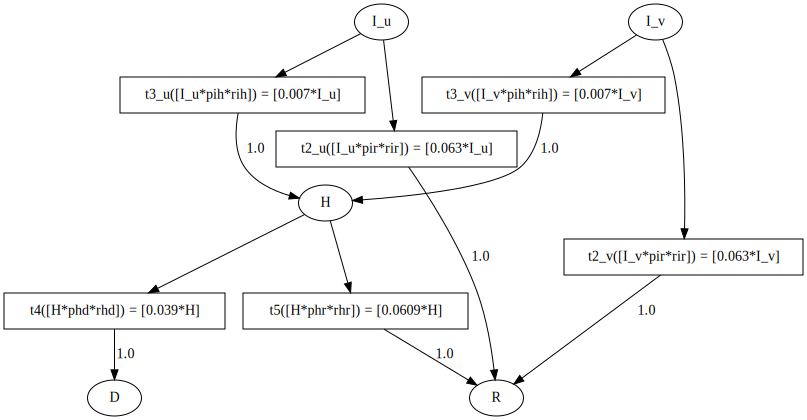

In [15]:
stratify(model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t3"], self_strata_transition=True).to_dot()


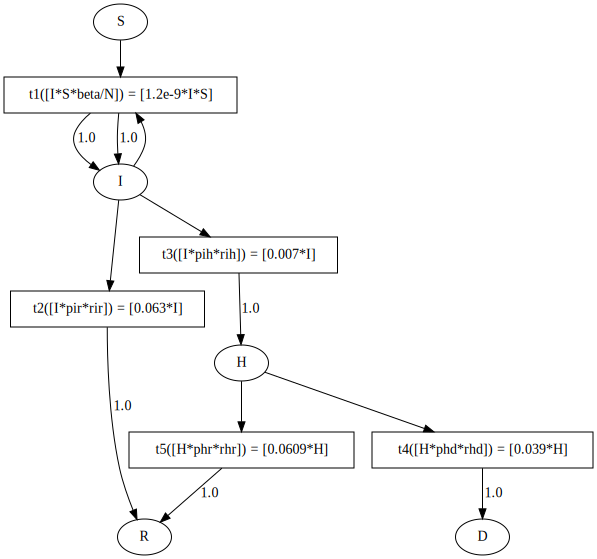

In [14]:
model.to_dot()

In [ ]:
model[0].to_dot()

TypeError: 'GeneratedPetriNetModel' object is not subscriptable